# Test speed of different datagenerators

This notebook is used to test different datagenerators. I'm especially interrested in the training speed of the different datagenerators. The total time to train the model is measured and also the gpu utilisation is visualized. A datagenerator using the tf.data and tf.keras.utils.Sequence API are tested. For comparison, all the data is also loaded beforehand and the model is trained (so without datagenerator). The [Kaggle Carvana Image Masking Challenge Dataset](https://www.kaggle.com/c/carvana-image-masking-challenge) is used to train a U-net model. Training is done in Google Colabs using a GPU.

This notebook is mainly based on https://github.com/tensorflow/models/blob/master/samples/outreach/blogs/segmentation_blogpost/image_segmentation.ipynb made by Raymond Yuan and https://github.com/afshinea/keras-data-generator made by Afshine Amidi.

### Basic stuff
Install and import libraries, download and visualize data

In [1]:
!pip install kaggle

In [2]:
import platform
print(platform.python_version())

3.6.7


In [0]:
import os
import zipfile
import functools

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
import subprocess

import tensorflow as tf
import tensorflow.contrib as tfcontrib
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.preprocessing.image import *
from tensorflow.python.keras import backend as K 

In [0]:
# Upload the API token so that we can use the Kaggle API.
def get_kaggle_credentials():
  token_dir = os.path.join(os.path.expanduser("~"),".kaggle")
  token_file = os.path.join(token_dir, "kaggle.json")
  if not os.path.isdir(token_dir):
    os.mkdir(token_dir)
  try:
    with open(token_file,'r') as f:
      pass
  except IOError as no_file:
    try:
      from google.colab import files
    except ImportError:
      raise no_file
    
    uploaded = files.upload()
    
    if "kaggle.json" not in uploaded:
      raise ValueError("You need an API key! see: "
                       "https://github.com/Kaggle/kaggle-api#api-credentials")
    with open(token_file, "wb") as f:
      f.write(uploaded["kaggle.json"])
    os.chmod(token_file, 600)

get_kaggle_credentials()

import kaggle

In [0]:
# Download data from Kaggle and unzip the files of interest (~25GB).
# You must accept the competition rules before downloading the data.
competition_name = 'carvana-image-masking-challenge'

def load_data_from_zip(competition, file):
  with zipfile.ZipFile(os.path.join(competition, file), "r") as zip_ref:
    unzipped_file = zip_ref.namelist()[0]
    zip_ref.extractall(competition)

def get_data(competition):
    kaggle.api.competition_download_files(competition, competition)
    load_data_from_zip(competition, 'train.zip')
    load_data_from_zip(competition, 'train_masks.zip')
    load_data_from_zip(competition, 'train_masks.csv.zip')

# Data is stored in /content/carvana-image-masking-challenge
get_data(competition_name)

In [6]:
# Show content of downloaded directory
directory = ""
dirs = os.listdir( os.path.join(competition_name,directory) )

# Print all the files and directories
for file in dirs:
   print(file)

train_masks.zip
train_masks.csv
test.zip
test_hq.zip
train
metadata.csv.zip
train_masks
29bb3ece3180_11.jpg
sample_submission.csv.zip
train_masks.csv.zip
train_hq.zip
train.zip


In [0]:
# Load filenames
img_dir = os.path.join(competition_name, "train")
label_dir = os.path.join(competition_name, "train_masks")

df_train = pd.read_csv(os.path.join(competition_name, 'train_masks.csv'))
ids_train = df_train['img'].map(lambda s: s.split('.')[0])

x_train_filenames = []
y_train_filenames = []
for img_id in ids_train:
  x_train_filenames.append(os.path.join(img_dir, "{}.jpg".format(img_id)))
  y_train_filenames.append(os.path.join(label_dir, "{}_mask.gif".format(img_id)))

In [8]:
# Split data in train and test set
x_train_filenames, x_val_filenames, y_train_filenames, y_val_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2, random_state=42)

num_train_examples = len(x_train_filenames)
num_val_examples = len(x_val_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples: {}".format(num_val_examples))

# Show example of filenames
print(x_train_filenames[:3])
print(y_train_filenames[:3])

Number of training examples: 4070
Number of validation examples: 1018
['carvana-image-masking-challenge/train/69915dab0755_16.jpg', 'carvana-image-masking-challenge/train/695f39dfac16_04.jpg', 'carvana-image-masking-challenge/train/2267f4aa0d2c_13.jpg']
['carvana-image-masking-challenge/train_masks/69915dab0755_16_mask.gif', 'carvana-image-masking-challenge/train_masks/695f39dfac16_04_mask.gif', 'carvana-image-masking-challenge/train_masks/2267f4aa0d2c_13_mask.gif']


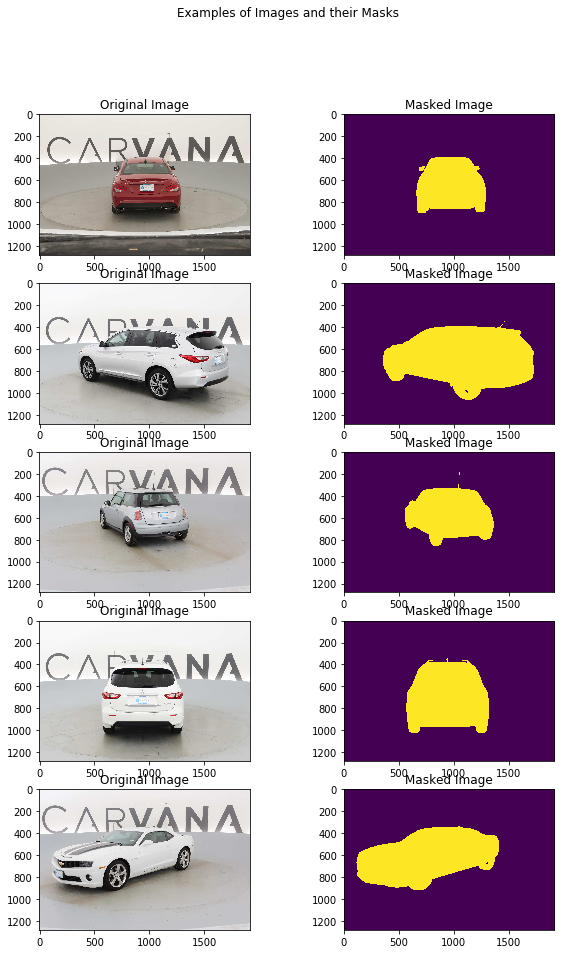

In [9]:
# Visualize the data
display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
  img_num = r_choices[i // 2]
  x_pathname = x_train_filenames[img_num]
  y_pathname = y_train_filenames[img_num]
  
  plt.subplot(display_num, 2, i + 1)
  plt.imshow(mpimg.imread(x_pathname))
  plt.title("Original Image")
  
  example_labels = Image.open(y_pathname)
  label_vals = np.unique(example_labels)
  
  plt.subplot(display_num, 2, i + 2)
  plt.imshow(example_labels)
  plt.title("Masked Image")  
  
plt.suptitle("Examples of Images and their Masks")
plt.show()

### Set trainings settings

In [0]:
img_shape = (256, 256, 3)
batch_size = 6
epochs = 3
num_workers = 8

### Build the model

In [11]:
# First declare some helper functions
def conv_block(input_tensor, num_filters):
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  return encoder

def encoder_block(input_tensor, num_filters):
  encoder = conv_block(input_tensor, num_filters)
  encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
  
  return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
  decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
  decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  return decoder

# Build the actual model, layer by layer
inputs = layers.Input(shape=img_shape)
# 256

encoder0_pool, encoder0 = encoder_block(inputs, 32)
# 128

encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
# 64

encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
# 32

encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
# 16

encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)
# 8

center = conv_block(encoder4_pool, 1024)
# center

decoder4 = decoder_block(center, encoder4, 512)
# 16

decoder3 = decoder_block(decoder4, encoder3, 256)
# 32

decoder2 = decoder_block(decoder3, encoder2, 128)
# 64

decoder1 = decoder_block(decoder2, encoder1, 64)
# 128

decoder0 = decoder_block(decoder1, encoder0, 32)
# 256

outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

# Define the model by specifying the input and output
model = models.Model(inputs=[inputs], outputs=[outputs])

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
# Define metrics and loss functions
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score
  
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

### Build datagenerator using tf.data (with data-augmentation)

In [0]:
def _process_pathnames(fname, label_path):
  # We map this function onto each pathname pair  
  img_str = tf.read_file(fname)
  img = tf.image.decode_jpeg(img_str, channels=3)

  label_img_str = tf.read_file(label_path)
  # These are gif images so they return as (num_frames, h, w, c)
  label_img = tf.image.decode_gif(label_img_str)[0]
  # The label image should only have values of 1 or 0, indicating pixel wise
  # object (car) or not (background). We take the first channel only. 
  label_img = label_img[:, :, 0]
  label_img = tf.expand_dims(label_img, axis=-1)
  return img, label_img

def shift_img(output_img, label_img, width_shift_range, height_shift_range):
  """This fn will perform the horizontal or vertical shift"""
  if width_shift_range or height_shift_range:
      if width_shift_range:
        width_shift_range = tf.random_uniform([], 
                                              -width_shift_range * img_shape[1],
                                              width_shift_range * img_shape[1])
      if height_shift_range:
        height_shift_range = tf.random_uniform([],
                                               -height_shift_range * img_shape[0],
                                               height_shift_range * img_shape[0])
      # Translate both 
      output_img = tfcontrib.image.translate(output_img,
                                             [width_shift_range, height_shift_range])
      label_img = tfcontrib.image.translate(label_img,
                                             [width_shift_range, height_shift_range])
  return output_img, label_img

def flip_img(horizontal_flip, tr_img, label_img):
  '''This  will flip the image horizontally'''
  if horizontal_flip:
    flip_prob = tf.random_uniform([], 0.0, 1.0)
    tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
  return tr_img, label_img

def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=False,  # Random left right flip,
             width_shift_range=0,  # Randomly translate the image horizontally
             height_shift_range=0):  # Randomly translate the image vertically
  '''This function applies all data-augmentation'''
  if resize is not None:
    # Resize both images
    label_img = tf.image.resize_images(label_img, resize)
    img = tf.image.resize_images(img, resize)
  
  if hue_delta:
    img = tf.image.random_hue(img, hue_delta)
  
  img, label_img = flip_img(horizontal_flip, img, label_img)
  img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
  label_img = tf.to_float(label_img) * scale
  img = tf.to_float(img) * scale 
  return img, label_img

def get_baseline_dataset(filenames, 
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=num_workers, 
                         batch_size=batch_size,
                         shuffle=True):           
  num_x = len(filenames)
  # Create a dataset from the filenames and labels
  dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
  # Map our preprocessing function to every element in our dataset, taking
  # advantage of multithreading
  dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)
  if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
    assert batch_size == 1, "Batching images must be of the same size"

  dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
  
  if shuffle:
    dataset = dataset.shuffle(num_x)
  
  # It's necessary to repeat our data for all epochs 
  dataset = dataset.repeat().batch(batch_size)
  return dataset

In [20]:
# Setup the train and validation datagenerators
tr_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
    'hue_delta': 0.1,
    'horizontal_flip': True,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1
}
tr_preprocessing_fn = functools.partial(_augment, **tr_cfg)

val_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
}
val_preprocessing_fn = functools.partial(_augment, **val_cfg)

train_ds = get_baseline_dataset(x_train_filenames,
                                y_train_filenames,
                                preproc_fn=tr_preprocessing_fn,
                                batch_size=batch_size)
val_ds = get_baseline_dataset(x_val_filenames,
                              y_val_filenames, 
                              preproc_fn=val_preprocessing_fn,
                              batch_size=batch_size)

Instructions for updating:
Use tf.cast instead.


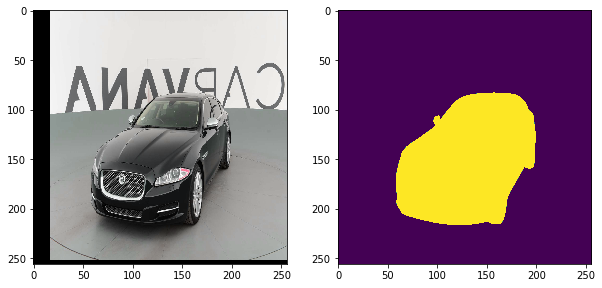

In [21]:
# Visualize the working of our datagenerator
temp_ds = get_baseline_dataset(x_train_filenames, 
                               y_train_filenames,
                               preproc_fn=tr_preprocessing_fn,
                               batch_size=1,
                               shuffle=False)
# Let's examine some of these augmented images
data_aug_iter = temp_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()
with tf.Session() as sess: 
  batch_of_imgs, label = sess.run(next_element)

  # Running next element in our graph will produce a batch of images
  plt.figure(figsize=(10, 10))
  img = batch_of_imgs[0]

  plt.subplot(1, 2, 1)
  plt.imshow(img)

  plt.subplot(1, 2, 2)
  plt.imshow(label[0, :, :, 0])
  plt.show()

### Train the model using the tf.data generator

In [22]:
# Compile the model and show summary
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss])

model.summary()

# Define callbacks
save_model_path = '/tmp/weights1.hdf5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_dice_loss', save_best_only=True, verbose=1)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
conv2d_1 (

In [23]:
# Start training and keep track of training time and gpu utilisation
%%time

# Keep track of gpu utilization
subprocess.Popen("timeout 1300 nvidia-smi --query-gpu=utilization.gpu,utilization.memory --format=csv -l 1 | sed s/%//g > ./GPU-stats1.log",shell=True)

#Started at 17.04
history = model.fit(train_ds, 
                   steps_per_epoch=int(np.floor(num_train_examples / float(batch_size))),
                   epochs=epochs,
                   validation_data=val_ds,
                   validation_steps=int(np.floor(num_val_examples / float(batch_size))),
                   callbacks=[cp])

Instructions for updating:
Use tf.cast instead.
Epoch 1/3
677/678 [============================>.] - ETA: 0s - loss: 0.5779 - dice_loss: 0.0541
Epoch 00001: val_dice_loss improved from inf to 0.02843, saving model to /tmp/weights1.hdf5
678/678 [==============================] - 445s 657ms/step - loss: 0.5774 - dice_loss: 0.0541 - val_loss: 0.4184 - val_dice_loss: 0.0284
Epoch 2/3
677/678 [============================>.] - ETA: 0s - loss: 0.2576 - dice_loss: 0.0216
Epoch 00002: val_dice_loss improved from 0.02843 to 0.01462, saving model to /tmp/weights1.hdf5
678/678 [==============================] - 289s 426ms/step - loss: 0.2576 - dice_loss: 0.0216 - val_loss: 0.1663 - val_dice_loss: 0.0146
Epoch 3/3
677/678 [============================>.] - ETA: 0s - loss: 0.1372 - dice_loss: 0.0117
Epoch 00003: val_dice_loss did not improve from 0.01462
678/678 [==============================] - 286s 422ms/step - loss: 0.1371 - dice_loss: 0.0117 - val_loss: 0.9410 - val_dice_loss: 0.0620
CPU times

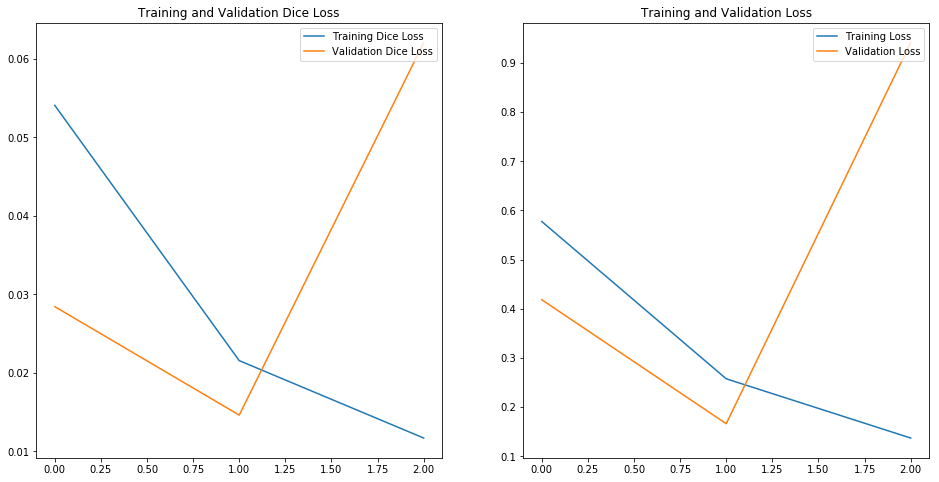

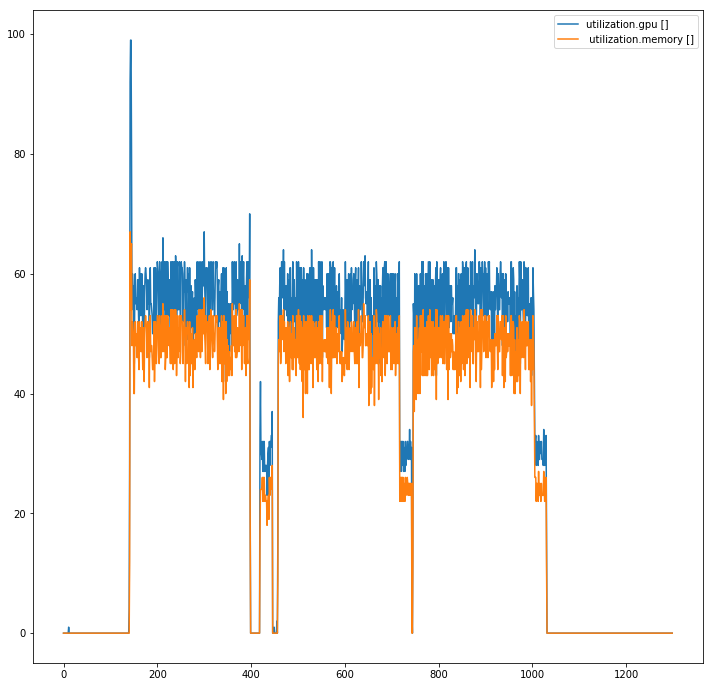

In [24]:
# Show trainingsprocess
dice = history.history['dice_loss']
val_dice = history.history['val_dice_loss']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, dice, label='Training Dice Loss')
plt.plot(epochs_range, val_dice, label='Validation Dice Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Dice Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

# GPU utilization
gpu = pd.read_csv("./GPU-stats1.log")
gpu.plot()
plt.show()

####Conclusion
Using the datagenerator build with tf.data it took around 17 minutes and 10 seconds to train the data. This is quite fast. However, the GPU utilization was on average below 60% so the datagenerator was the bottleneck. 

### Build datagenerator using tf.keras.utils.Sequence (with data-augmentation)

In [0]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, x_paths, y_paths, batch_size=32, x_shape=(128,128,3), scale=1.,
                 horizontal_flip=False, vertical_flip=False, shift_range=None, 
                 rotation_range=0, shear_range=0, zoom_range=None, brightness_range=None,
                 hue_shift_range=0, shuffle=True, drop_remainder=True):
        'Initialization'
        self.x_shape = x_shape
        self.batch_size = batch_size
        self.x_paths = x_paths
        self.y_paths = y_paths
        self.shuffle = shuffle
        self.scale = scale
        self.horizontal_flip = horizontal_flip
        self.vertical_flip = vertical_flip
        self.shift_range = shift_range
        if shift_range is not None:
          self.width_shift_range = shift_range[0]
          self.height_shift_range = shift_range[1]
        self.rotation_range = rotation_range
        self.shear_range = shear_range
        self.zoom_range = zoom_range
        self.brightness_range = brightness_range
        self.hue_shift_range = hue_shift_range
        self.drop_remainder = drop_remainder
        self.on_epoch_end()
        
        if np.mod(len(self.x_paths), self.batch_size) != 0:
          print(f'Warning, {np.mod(len(self.x_paths), self.batch_size)} sample(s) are not used in an epoch')

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.x_paths) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, Y = self.__load_data(indexes)
        
        #Do augmentation
        # See: https://github.com/keras-team/keras-preprocessing/blob/master/keras_preprocessing/image/affine_transformations.py
        X = X*self.scale
        Y = Y*self.scale
        if self.brightness_range is not None:
          X = self.__apply_brightness_shift_rand(X)
        if self.hue_shift_range:
          X = self.__apply_hue_shift_rand(X)
        X, Y = self.__flip_img_hor_rand(X, Y)
        X, Y = self.__flip_img_ver_rand(X, Y)
        if self.zoom_range is not None:
          X, Y = self.__zoom_img_rand(X, Y)
        if self.shift_range is not None:
          X, Y = self.__shift_img_rand(X, Y)
        if self.rotation_range:
          X, Y = self.__rotation_img_rand(X, Y)
        if self.shear_range:
          X, Y = self.__shear_img_rand(X, Y)
        
        return X, Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.x_paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __load_data(self, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, x_shape)
        # Initialization
        X = np.empty((self.batch_size, *self.x_shape))
        Y = np.empty((self.batch_size, self.x_shape[0], self.x_shape[1], 1))

        # Generate data
        for i, ID in enumerate(indexes):
            # Store sample
            X[i,] = image.load_img(self.x_paths[ID],
                      target_size=(self.x_shape[0],self.x_shape[1]))

            # Store label
            Y[i,:,:,0] = image.load_img(self.y_paths[ID],
                      target_size=(self.x_shape[0],self.x_shape[1]), color_mode = "grayscale")
            
        return X, Y
      
    def __flip_img_hor_rand(self, x, y):
        if self.horizontal_flip:
          for ii in range(x.shape[0]):
            flip_prob = np.random.rand()
            if flip_prob <= 0.5:
              x[ii] = np.flip(x[ii], axis=1)
              y[ii] = np.flip(y[ii], axis=1)
        return x, y
      
    def __flip_img_ver_rand(self, x, y):
        if self.vertical_flip:
          for ii in range(x.shape[0]):
            flip_prob = np.random.rand()
            if flip_prob <= 0.5:
              x[ii] = np.flip(x[ii], axis=0)
              y[ii] = np.flip(y[ii], axis=0)
        return x, y
      
    def __shift_img_rand(self, x, y, row_axis=1, col_axis=2, channel_axis=3,
                 fill_mode='nearest', cval=0., interpolation_order=1):
        # From https://github.com/keras-team/keras-preprocessing/blob/master/keras_preprocessing/image/affine_transformations.py
        # When self.shift_range = (0.,0.), no shift will be applied
        h, w = x.shape[row_axis], x.shape[col_axis]
        for ii in range(x.shape[0]):
          tx = np.random.uniform(-self.height_shift_range, self.height_shift_range) * h
          ty = np.random.uniform(-self.width_shift_range, self.width_shift_range) * w
          x[ii] = apply_affine_transform(x[ii], tx=tx, ty=ty, channel_axis=channel_axis-1,
                               fill_mode=fill_mode, cval=cval, order=interpolation_order)
          y[ii] = apply_affine_transform(y[ii], tx=tx, ty=ty, channel_axis=channel_axis-1,
                               fill_mode=fill_mode, cval=cval, order=interpolation_order)
        return x, y
      
    def __rotation_img_rand(self, x, y, row_axis=1, col_axis=2, channel_axis=3,
                 fill_mode='nearest', cval=0., interpolation_order=1):
        for ii in range(x.shape[0]):
          theta = np.random.uniform(-self.rotation_range, self.rotation_range)
          x[ii] = apply_affine_transform(x[ii], theta=theta, channel_axis=channel_axis-1,
                               fill_mode=fill_mode, cval=cval, order=interpolation_order)
          y[ii] = apply_affine_transform(y[ii], theta=theta, channel_axis=channel_axis-1,
                               fill_mode=fill_mode, cval=cval, order=interpolation_order)
        return x, y
      
    def __shear_img_rand(self, x, y, row_axis=1, col_axis=2, channel_axis=3,
                 fill_mode='nearest', cval=0., interpolation_order=1):
        for ii in range(x.shape[0]):
          shear = np.random.uniform(-self.shear_range, self.shear_range)
          x[ii] = apply_affine_transform(x[ii], shear=shear, channel_axis=channel_axis-1,
                               fill_mode=fill_mode, cval=cval, order=interpolation_order)
          y[ii] = apply_affine_transform(y[ii], shear=shear, channel_axis=channel_axis-1,
                               fill_mode=fill_mode, cval=cval, order=interpolation_order)
        return x, y
    
    def __zoom_img_rand(self, x, y, row_axis=1, col_axis=2, channel_axis=3,
                 fill_mode='nearest', cval=0., interpolation_order=1):
      # When self.zoom_range = (1, 1), no zoom will be applied
        for ii in range(x.shape[0]):
          zx, zy = np.random.uniform(self.zoom_range[0], self.zoom_range[1], 2)
          x[ii] = apply_affine_transform(x[ii], zx=zx, zy=zy, channel_axis=channel_axis-1,
                               fill_mode=fill_mode, cval=cval, order=interpolation_order)
          y[ii] = apply_affine_transform(y[ii], zx=zx, zy=zy, channel_axis=channel_axis-1,
                               fill_mode=fill_mode, cval=cval, order=interpolation_order)
        return x, y
    
    def __apply_brightness_shift_rand(self, x):
      # When self.brightness_range = (1, 1), the brightness will stay the same
        for ii in range(x.shape[0]):
          u = np.random.uniform(self.brightness_range[0], self.brightness_range[1])
          x[ii] = apply_brightness_shift(x[ii]*255, u)
        return x/255.
    
    def __apply_hue_shift_rand(self, x):
        for ii in range(x.shape[0]):
          u = np.random.uniform(-self.hue_shift_range, self.hue_shift_range)
          x[ii] = mpl.colors.rgb_to_hsv(x[ii])
          x[ii,:,:,0] = np.mod(x[ii,:,:,0]+u,1)
          x[ii] = mpl.colors.hsv_to_rgb(x[ii])
        return x

In [14]:
# Setup the train and validation datagenerators
params_train = {'batch_size': batch_size,
                'x_shape': img_shape,
                'scale': 1/255.,
                'horizontal_flip': True,
                'vertical_flip': False,
                'shift_range': (0.1, 0.1),
                #'rotation_range': 3., #degree
                #'shear_range': 1.,#degree
                #'zoom_range': (0.9, 1.1),
                #'brightness_range': (0.95, 1.05), 
                'hue_shift_range': 0.1,
                'shuffle': True,
                'drop_remainder': True}
params_val = {'batch_size': batch_size,
              'x_shape': img_shape,
              'scale': 1/255.,
              'shuffle': False}

training_generator = DataGenerator(x_train_filenames,y_train_filenames, **params_train)
validation_generator = DataGenerator(x_val_filenames,y_val_filenames, **params_val)

Warning, 2 sample(s) are not used in an epoch
Warning, 4 sample(s) are not used in an epoch


(6, 256, 256, 3)
(6, 256, 256, 1)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


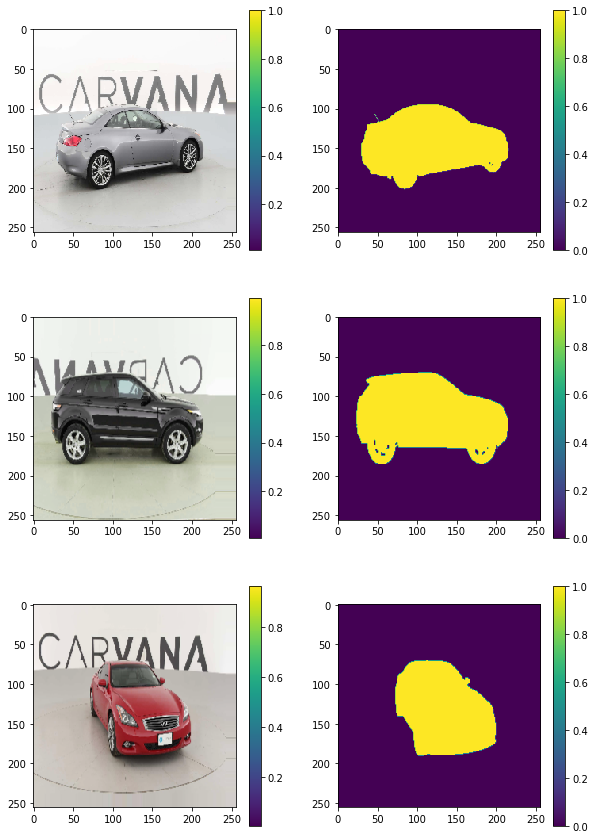

In [15]:
# Visualize the working of our datagenerator
my_iter = iter(training_generator)

img, img_lab = next(my_iter)
print(img.shape)
print(img_lab.shape)
print(type(img))
print(type(img_lab))

plt.figure(figsize=(10,15))
for i in range(3):
  plt.subplot(3,2,2*i+1)
  plt.imshow(img[i])
  plt.colorbar()
  plt.subplot(3,2,2*i+2)
  plt.imshow(img_lab[i,:,:,0])
  plt.colorbar()

### Train the model using the tf.keras.utils.Sequence datagenerator

In [16]:
# Compile the model and show summary
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss])

model.summary()

# Define callbacks
save_model_path = '/tmp/weights2.hdf5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_dice_loss', save_best_only=True, verbose=1)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
conv2d_1 (

In [17]:
# Start training and keep track of training time and gpu utilisation
%%time

# Keep track of gpu utilization
subprocess.Popen("timeout 1300 nvidia-smi --query-gpu=utilization.gpu,utilization.memory --format=csv -l 1 | sed s/%//g > ./GPU-stats2.log",shell=True)

#Started at 18.04
history = model.fit_generator(generator=training_generator,
                   validation_data=validation_generator,
                   epochs=epochs,
                   use_multiprocessing=True,
                   workers=num_workers,
                   callbacks=[cp])

Instructions for updating:
Use tf.cast instead.
Epoch 1/3
169/169 [==============================] - 47s 278ms/step - loss: 0.2207 - dice_loss: 0.0209

Epoch 00001: val_dice_loss improved from inf to 0.02089, saving model to /tmp/weights2.hdf5
678/678 [==============================] - 365s 538ms/step - loss: 0.6591 - dice_loss: 0.0623 - val_loss: 0.2207 - val_dice_loss: 0.0209
Epoch 2/3
169/169 [==============================] - 46s 270ms/step - loss: 0.8721 - dice_loss: 0.0593

Epoch 00002: val_dice_loss did not improve from 0.02089
678/678 [==============================] - 349s 514ms/step - loss: 0.2360 - dice_loss: 0.0204 - val_loss: 0.8721 - val_dice_loss: 0.0593
Epoch 3/3
169/169 [==============================] - 47s 279ms/step - loss: 0.1565 - dice_loss: 0.0145

Epoch 00003: val_dice_loss improved from 0.02089 to 0.01450, saving model to /tmp/weights2.hdf5
678/678 [==============================] - 347s 512ms/step - loss: 0.2139 - dice_loss: 0.0181 - val_loss: 0.1565 - val_dic

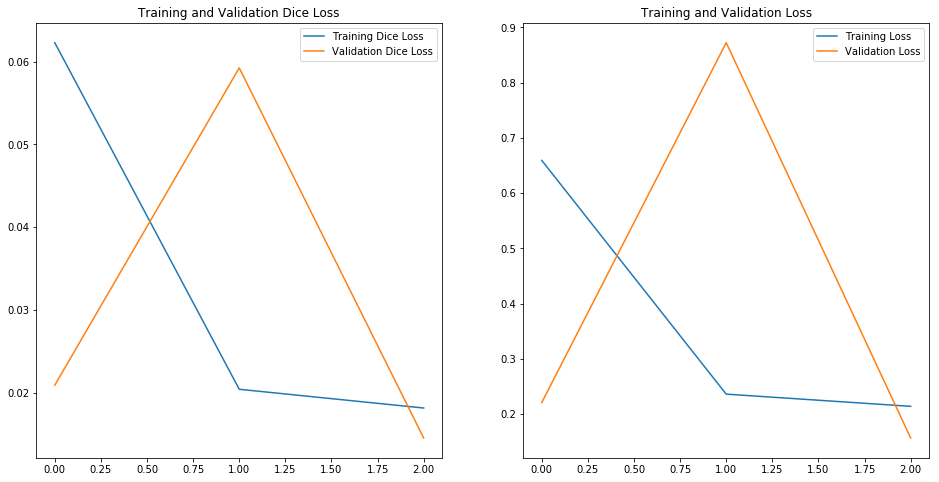

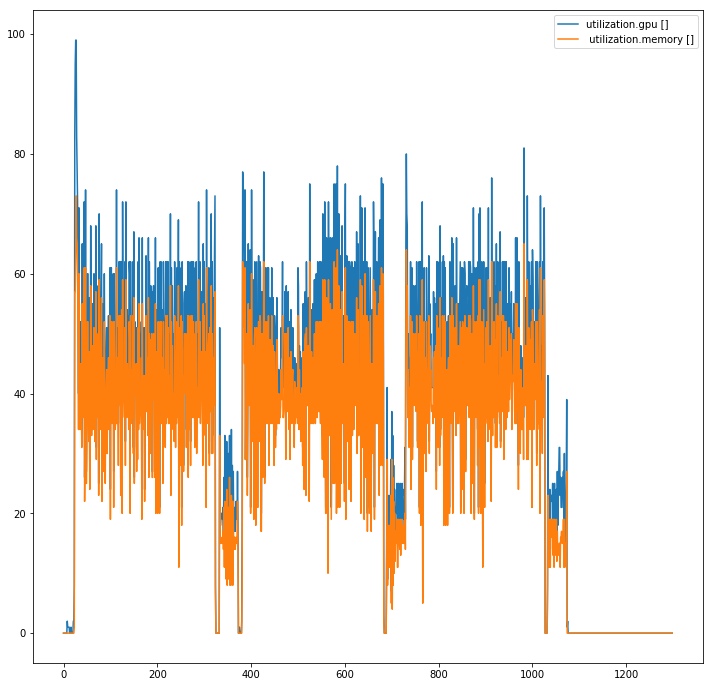

In [18]:
# Show trainingsprocess
dice = history.history['dice_loss']
val_dice = history.history['val_dice_loss']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, dice, label='Training Dice Loss')
plt.plot(epochs_range, val_dice, label='Validation Dice Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Dice Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

# GPU utilization
gpu = pd.read_csv("./GPU-stats2.log")
gpu.plot()
plt.show()

####Conclusion
Using the tf.keras.utils.Sequence datagenerator training took a little bit longer, namely 17 minutes and 56 seconds. The GPU utilization was again on average below 60%. The datagenerator using the tf.keras.utils.Sequence performed slightly worse. 

### Train the model without datagenerator (also no data-augmentation)
For comparison, the model is also trained without datagenerator. This should be the fastest way to train because the datagenerator can't be a bottleneck. The GPU utilization should be close to 100% during training. Only a third of the train and validation data will be used because not all data will fit in memory.

In [0]:
# Load all data
# Initialization
AllDataX_train = np.empty((len(x_train_filenames)//3, *img_shape))
AllDataY_train = np.empty((len(y_train_filenames)//3, img_shape[0], img_shape[1], 1))

# Generate data
for i in range(AllDataX_train.shape[0]):
  # Store sample
  AllDataX_train[i,] = image.load_img(x_train_filenames[i],
               target_size=(img_shape[0],img_shape[1]))

  # Store label
  AllDataY_train[i,:,:,0] = image.load_img(y_train_filenames[i],
              target_size=(img_shape[0],img_shape[1]), color_mode = "grayscale")
  
AllDataX_train = AllDataX_train/255.
AllDataY_train = AllDataY_train/255.
  
AllDataX_val = np.empty((len(x_val_filenames)//3, *img_shape))
AllDataY_val = np.empty((len(y_val_filenames)//3, img_shape[0], img_shape[1], 1))

# Generate data
for i in range(AllDataX_val.shape[0]):
  # Store sample
  AllDataX_val[i,] = image.load_img(x_val_filenames[i],
               target_size=(img_shape[0],img_shape[1]))

  # Store label
  AllDataY_val[i,:,:,0] = image.load_img(y_val_filenames[i],
              target_size=(img_shape[0],img_shape[1]), color_mode = "grayscale")
  
AllDataX_val = AllDataX_val/255.
AllDataY_val = AllDataY_val/255.

In [20]:
# Compile the model and show summary
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss])

model.summary()

# Define callbacks
save_model_path = '/tmp/weights3.hdf5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_dice_loss', save_best_only=True, verbose=1)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
conv2d_1 (

In [21]:
# Start training and keep track of training time and gpu utilisation
%%time

# Keep track of gpu utilization
subprocess.Popen("timeout 240 nvidia-smi --query-gpu=utilization.gpu,utilization.memory --format=csv -l 1 | sed s/%//g > ./GPU-stats3.log",shell=True)

#Started at 16.47
history = model.fit(x=AllDataX_train,
                    y=AllDataY_train,
                    validation_data=(AllDataX_val,AllDataY_val),
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[cp])

Train on 1356 samples, validate on 339 samples
Epoch 1/3
1350/1356 [============================>.] - ETA: 0s - loss: 0.1537 - dice_loss: 0.0130
Epoch 00001: val_dice_loss improved from inf to 0.01250, saving model to /tmp/weights3.hdf5
1356/1356 [==============================] - 64s 47ms/sample - loss: 0.1535 - dice_loss: 0.0129 - val_loss: 0.1451 - val_dice_loss: 0.0125
Epoch 2/3
1350/1356 [============================>.] - ETA: 0s - loss: 0.1190 - dice_loss: 0.0101
Epoch 00002: val_dice_loss did not improve from 0.01250
1356/1356 [==============================] - 56s 42ms/sample - loss: 0.1190 - dice_loss: 0.0101 - val_loss: 0.2406 - val_dice_loss: 0.0187
Epoch 3/3
1350/1356 [============================>.] - ETA: 0s - loss: 0.2563 - dice_loss: 0.0203
Epoch 00003: val_dice_loss did not improve from 0.01250
1356/1356 [==============================] - 56s 42ms/sample - loss: 0.2559 - dice_loss: 0.0203 - val_loss: 2.3281 - val_dice_loss: 0.0995
CPU times: user 1min 46s, sys: 50.4 s,

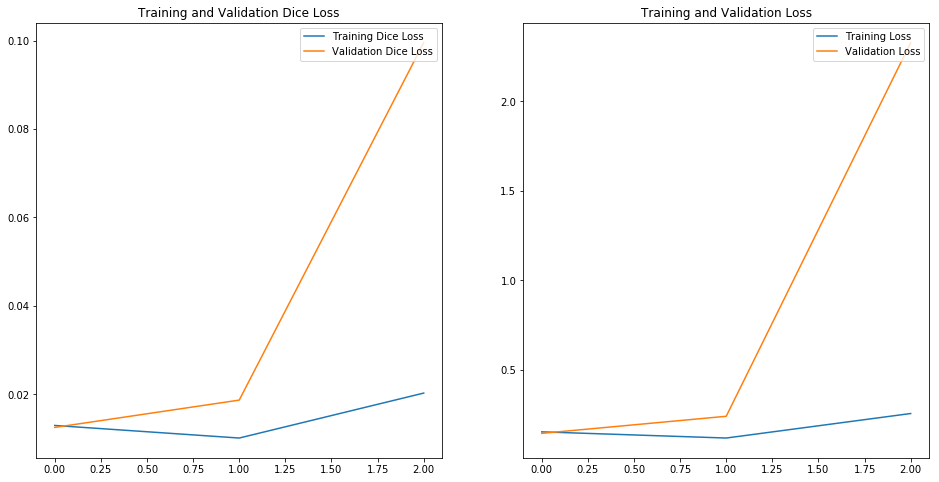

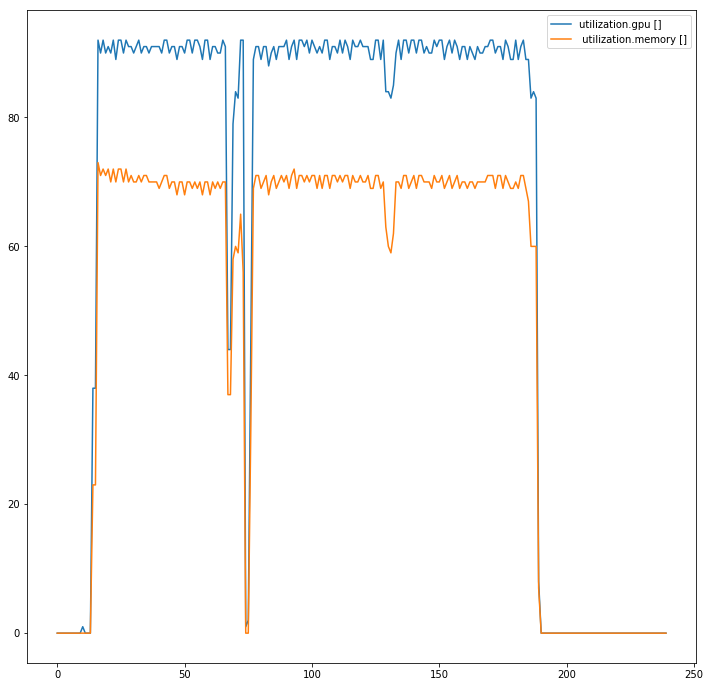

In [22]:
# Show trainingsprocess
dice = history.history['dice_loss']
val_dice = history.history['val_dice_loss']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, dice, label='Training Dice Loss')
plt.plot(epochs_range, val_dice, label='Validation Dice Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Dice Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

# GPU utilization
gpu = pd.read_csv("./GPU-stats3.log")
gpu.plot()
plt.show()

####Conclusion
As expected, training without datagenerator is faster. Training took only 3 minutes and 7 seconds, but keep in mind that only one third of the data is used and that there was no real-time data-augmentation. The GPU utilization was close to 100% so there was no bottleneck in the supply of data. I will be using the tf.keras.utils.Sequence datagenerator because I prefer the API and the difference in speed between the tf.data and tf.keras.utils.Sequence generators is small. When no data-augmentation is used, both datagenerators perform faster.